<h1> <a href=http://www.datascience-paris-saclay.fr/>Paris Saclay Center for Data Science</a> </h1>

<h2> Titanic RAMP: survival prediction of Titanic passengers </h2>

<i> Benoit Playe (Institut Curie/Mines ParisTech), Chloé-Agathe Azencott (Institut Curie/Mines ParisTech), Alex Gramfort (LTCI/Télécom ParisTech), Balázs Kégl (LAL/CNRS)</i>

<h2> Introduction </h2>
This project is an initiation project to introduce RAMP and make you comfortable with its functioning.

The goal is to develop prediction models able to <b> identify people who survived from the Titanic shinking based on gender, age and ticket's information</b>.  

The data we'll manipulate is from the <a href=https://www.kaggle.com/c/titanic-gettingStarted>Titanic kaggle challenge</a>.

### Requirements

* numpy>=1.10.0  
* matplotlib>=1.5.0 
* pandas>=0.19.0  
* scikit-learn>=0.17 (different syntaxes for v0.17 and v0.18)   
* seaborn>=0.7.1

In [2]:
%matplotlib inline
import os
import glob
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd

## Exploratory data analysis

### Loading the data

In [4]:
train_filename = 'train.csv'
data = pd.read_csv(train_filename)
y_df = data['Survived']
X_df = data.drop(['Survived', 'PassengerId'], axis=1)
X_df.head(5)

Pclass                                   Name     Sex   Age  SibSp  Parch  \
0       3  Asplund, Master. Clarence Gustaf Hugo    male   9.0      4      2   
1       3       Petroff, Mr. Pastcho ("Pentcho")    male   NaN      0      0   
2       1           Hippach, Miss. Jean Gertrude  female  16.0      0      1   
3       3          Skoog, Miss. Margit Elizabeth  female   2.0      3      2   
4       3                    Novel, Mr. Mansouer    male  28.5      0      0   

   Ticket     Fare Cabin Embarked  
0  347077  31.3875   NaN        S  
1  349215   7.8958   NaN        S  
2  111361  57.9792   B18        C  
3  347088  27.9000   NaN        S  
4    2697   7.2292   NaN        C

In [6]:
data.head(5)

PassengerId  Survived  Pclass                                   Name  \
0          183         0       3  Asplund, Master. Clarence Gustaf Hugo   
1          102         0       3       Petroff, Mr. Pastcho ("Pentcho")   
2          330         1       1           Hippach, Miss. Jean Gertrude   
3          643         0       3          Skoog, Miss. Margit Elizabeth   
4           58         0       3                    Novel, Mr. Mansouer   

      Sex   Age  SibSp  Parch  Ticket     Fare Cabin Embarked  
0    male   9.0      4      2  347077  31.3875   NaN        S  
1    male   NaN      0      0  349215   7.8958   NaN        S  
2  female  16.0      0      1  111361  57.9792   B18        C  
3  female   2.0      3      2  347088  27.9000   NaN        S  
4    male  28.5      0      0    2697   7.2292   NaN        C

In [5]:
y_df.head(5)

0    0
1    0
2    1
3    0
4    0
Name: Survived, dtype: int64

In [29]:
data.describe()

PassengerId   Survived      Pclass         Age       SibSp       Parch  \
count   445.000000  445.00000  445.000000  356.000000  445.000000  445.000000   
mean    446.274157    0.38427    2.312360   28.761236    0.559551    0.404494   
std     259.362344    0.48697    0.832317   14.225454    1.169885    0.792975   
min       2.000000    0.00000    1.000000    0.750000    0.000000    0.000000   
25%     220.000000    0.00000    2.000000         NaN    0.000000    0.000000   
50%     439.000000    0.00000    3.000000         NaN    0.000000    0.000000   
75%     670.000000    1.00000    3.000000         NaN    1.000000    1.000000   
max     890.000000    1.00000    3.000000   71.000000    8.000000    6.000000   

             Fare  
count  445.000000  
mean    33.503707  
std     53.120685  
min      0.000000  
25%      7.925000  
50%     15.245800  
75%     31.387500  
max    512.329200

In [30]:
data.count()

PassengerId    445
Survived       445
Pclass         445
Name           445
Sex            445
Age            356
SibSp          445
Parch          445
Ticket         445
Fare           445
Cabin          101
Embarked       445
dtype: int64

The data frame has 891 rows. Some passengers have missing information though: in particular Age and Cabin info can be missing. The meaning of the columns is explained on the challenge website:

https://www.kaggle.com/c/titanic-gettingStarted/data

### Predicting survival

The goal is to predict whether a passenger has survived from others known attribute. Let us group the data according to the `Survived` columns:

In [31]:
data.groupby('Survived').count()

PassengerId  Pclass  Name  Sex  Age  SibSp  Parch  Ticket  Fare  \
Survived                                                                    
0                 274     274   274  274  216    274    274     274   274   
1                 171     171   171  171  140    171    171     171   171   

          Cabin  Embarked  
Survived                   
0            33       274  
1            68       171

About two thirds of the passengers perished in the event. A dummy classifier that systematically returns "0" would have an accuracy of 62%, higher than that of a random model.

### Some plots

#### Features densities and co-evolution
A scatterplot matrix allows us to visualize:
* on the diagonal, the density estimation for each of the features
* on each of the off-diagonal plots, a scatterplot between two of the features. Each dot represents a sample.

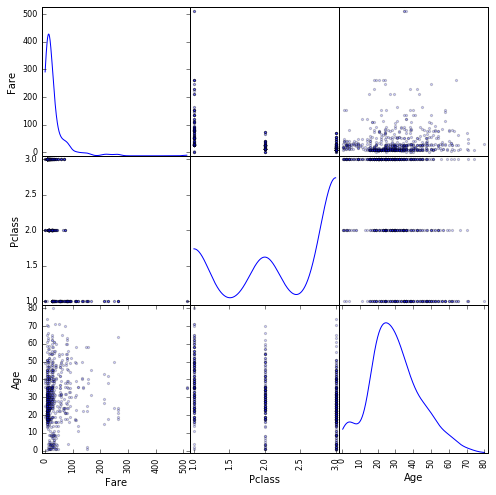

In [7]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(data.get(['Fare', 'Pclass', 'Age']), alpha=0.2,
               figsize=(8, 8), diagonal='kde');

#### Non-linearly transformed data

The 'Fare' variable has a very heavy tail. We can log-transform it. 

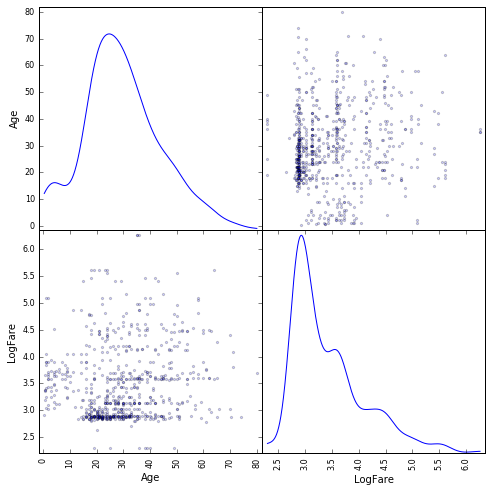

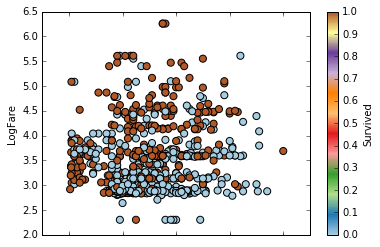

In [8]:
data_plot = data.get(['Age', 'Survived'])
data_plot = data.assign(LogFare=lambda x : np.log(x.Fare + 10.))
scatter_matrix(data_plot.get(['Age', 'LogFare']), alpha=0.2, figsize=(8, 8), diagonal='kde');

data_plot.plot(kind='scatter', x='Age', y='LogFare', c='Survived', s=50, cmap=plt.cm.Paired);

#### Plot of two variables bivariate and univariate distributions

Another way of visualizing relationships between variables is to plot their bivariate distributions.

:0: FutureWarning: IPython widgets are experimental and may change in the future.


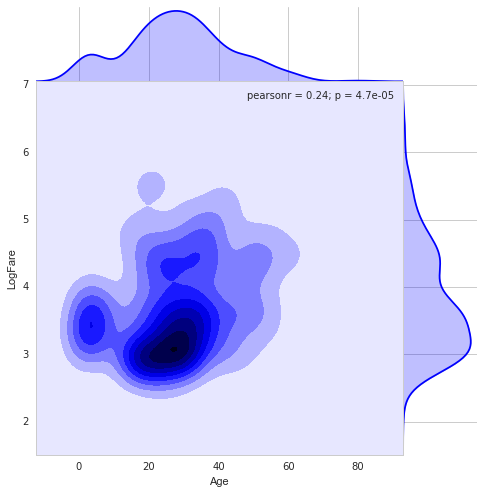

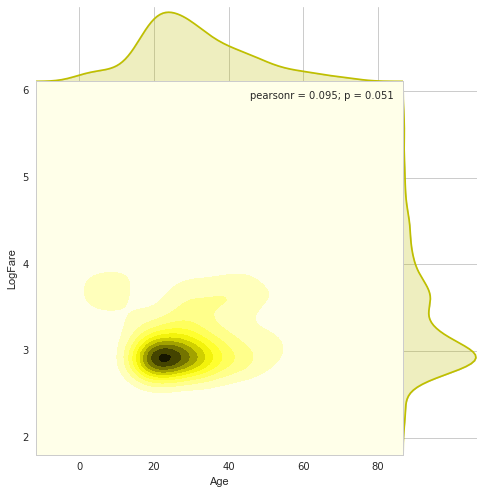

In [9]:
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
sns.jointplot(data_plot.Age[data_plot.Survived == 1],
              data_plot.LogFare[data_plot.Survived == 1],
              kind="kde", size=7, space=0, color="b");

sns.jointplot(data_plot.Age[data_plot.Survived == 0],
              data_plot.LogFare[data_plot.Survived == 0],
              kind="kde", size=7, space=0, color="y");

## Submission

For your submissions, you have to write 2 classes, saved in 2 different files:   
* the class <code>FeatureExtractor</code>, which will be used to extract features for classification from the dataset and produce a numpy array of size (number of samples, dim of features).  
* a class <code>Classifier</code> to predict the molecule type  

When submitting these files, they are uploaded to our servers and run to give you a score!  

### Feature extractor

The feature extractor for classification is implemented by the function <code>transform</code> and is saved in the file <code>feature_extractor.py</code>. It receives the pandas dataframe <code>X_df</code> defined at the beginning of the notebook. It should produce a numpy array representing the features extracted, which would be used for the classification.  

Below is an example of a feature extractor. You can copy-paste it into your <code>feature_extractor.py</code> file or write a new one!

In [11]:
import numpy as np
import pandas as pd

class FeatureExtractor():
    def __init__(self):
        pass

    def fit(self, X_df, y):
        pass

    def transform(self, X_df):
        X_df_new = pd.concat(
            [X_df.get(['Fare', 'Age']),
            pd.get_dummies(X_df.Sex, prefix='Sex', drop_first=True),
            pd.get_dummies(X_df.Pclass, prefix='Pclass', drop_first=True),
            pd.get_dummies(X_df.Embarked, prefix='Embarked', drop_first=True)],
            axis=1)
        X_df_new = X_df_new.fillna(-1)
        XX = X_df_new.values
        return XX

### Classifier

The classifier follows a classical scikit-learn classifier template. It should be saved in the file <code>classifier.py</code>. In its simplest form it takes a scikit-learn pipeline and assignes it to <code>self.clf</code> in <code>__init__</code>.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator


class Classifier(BaseEstimator):
    def __init__(self):
        self.clf =  Pipeline([
            ('imputer', Imputer(strategy='median')),
            ('classifier', LogisticRegression(C=1.))
        ])

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

## Unit testing

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Place the python files <code>classifier.py</code>, <code>feature_extractor.py</code>, <code>user_test_submission.py</code> in a directory. Det the paths to the data files in <code>user_test_submission.py</code>, and run 

<code>python user_test_submission.py</code>


**If it runs and prints**   
```
Reading file ...
Training file ...
--------------------------
roc auc score = some_number_between_0_and_1
--------------------------
roc auc score = some_number_between_0_and_1
--------------------------
roc auc score = some_number_between_0_and_1
--------------------------
roc auc score = some_number_between_0_and_1
--------------------------
roc auc score = some_number_between_0_and_1
```
**then, you can submit the code.**

To run user_test_submission.py and test your code from the notebook you can do:

In [27]:
!python user_test_submission.py

Reading file ...
Training file ...
--------------------------
('roc auc score = ', 0.83399209486166004)
--------------------------
('roc auc score = ', 0.86363636363636376)
--------------------------
('roc auc score = ', 0.86100131752305664)
--------------------------
('roc auc score = ', 0.85770750988142297)
--------------------------
('roc auc score = ', 0.87793148880105398)
